Load in Data from .mat files

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

In [2]:
hg_trace, hg_map, phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 128)
(149, 8, 16, 200)
(149, 3)


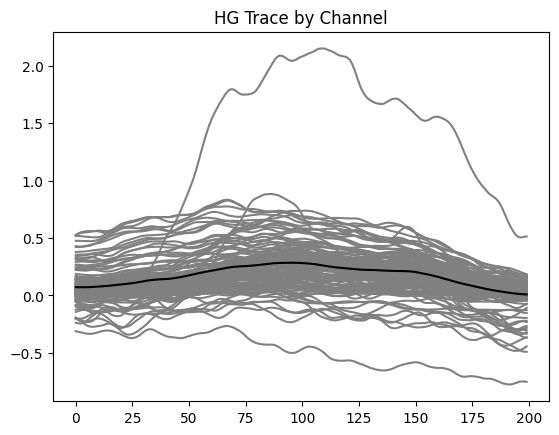

In [3]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [4]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [5]:
# parameters
n_output = 10

In [6]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X = hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [7]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 200, 128) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [8]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model, 
                                       lstm_3Dcnn_model, gru_3Dcnn_model)


In [9]:
# parameters

# 1D CNN
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 100
n_units = 800
reg_lambda = 1e-6
bidir = False

In [10]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = lstm_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [11]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 128)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 100)      128100      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    5486410     ['conv1d[0][0]',                 
 nal)                                                             'input_2[0][0]

### Hyperparameter Optimization

In [27]:
import keras_tuner as kt
from sklearn.model_selection import ShuffleSplit
from train.optimize import encDecHyperModel, encDecTuner

In [46]:
data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [30]:
optim_trials = 5
hyper_model = encDecHyperModel(lstm_1Dcnn_model, n_input_time, n_input_channel, n_output)
rnn_optimizer = encDecTuner(hypermodel=hyper_model,
                            oracle=kt.oracles.RandomSearchOracle(objective=kt.Objective('val_accuracy', direction='max'),
                                                                 max_trials=optim_trials),
                            directory='data/rnn_tuning', project_name='S14_1Dcnn_LSTM')

In [31]:
rnn_optimizer.search(X_train, X_prior_train, y_train, epochs=1)

Trial 5 Complete [00h 02m 31s]
val_accuracy: 0.11518564265089311

Best val_accuracy So Far: 0.11518564265089311
Total elapsed time: 00h 11m 09s
INFO:tensorflow:Oracle triggered exit


In [32]:
rnn_optimizer.results_summary()

Results summary
Results in data/rnn_tuning\S14_1Dcnn_LSTM
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
num_filts: 170
rnn_units: 300
reg_lambda: 1e-05
Score: 0.11518564265089311

Trial 3 summary
Hyperparameters:
num_filts: 140
rnn_units: 200
reg_lambda: 0.0001
Score: 0.10649229979044648

Trial 0 summary
Hyperparameters:
num_filts: 120
rnn_units: 600
reg_lambda: 0.1
Score: 0.10195207870048328

Trial 1 summary
Hyperparameters:
num_filts: 120
rnn_units: 500
reg_lambda: 1e-05
Score: 0.10056673947420516

Trial 2 summary
Hyperparameters:
num_filts: 110
rnn_units: 100
reg_lambda: 0.0001
Score: 0.09402313193728527


In [38]:
optim_params = rnn_optimizer.get_best_hyperparameters(num_trials=1)[0].values

In [39]:
from keras.optimizers import Adam
optim_model, optim_enc, optim_dec = lstm_1Dcnn_model(n_input_time, n_input_channel,
                                                     n_output, n_filters=optim_params['num_filts'],
                                                     filter_size=10, n_units=optim_params['rnn_units'],
                                                     reg_lambda=optim_params['reg_lambda'])

learning_rate = 1e-5
optim_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
from train.train import train_seq2seq, decode_seq2seq

_, histories = train_seq2seq(optim_model, X_train, X_prior_train, y_train, epochs=10)


Epoch 1/10
1/1 [==============================] - 1s 541ms/step - loss: 2.3022 - accuracy: 0.1429
Epoch 2/10
1/1 [==============================] - 0s 495ms/step - loss: 2.2997 - accuracy: 0.1429
Epoch 3/10
1/1 [==============================] - 0s 484ms/step - loss: 2.2972 - accuracy: 0.1485
Epoch 4/10
1/1 [==============================] - 1s 540ms/step - loss: 2.2948 - accuracy: 0.1569
Epoch 5/10
1/1 [==============================] - 1s 514ms/step - loss: 2.2923 - accuracy: 0.1597
Epoch 6/10
1/1 [==============================] - 1s 514ms/step - loss: 2.2899 - accuracy: 0.1569
Epoch 7/10
1/1 [==============================] - 0s 471ms/step - loss: 2.2875 - accuracy: 0.1653
Epoch 8/10
1/1 [==============================] - 0s 471ms/step - loss: 2.2851 - accuracy: 0.1625
Epoch 9/10
1/1 [==============================] - 1s 509ms/step - loss: 2.2828 - accuracy: 0.1765
Epoch 10/10
1/1 [==============================] - 0s 470ms/step - loss: 2.2805 - accuracy: 0.1765


In [47]:
from sklearn.metrics import balanced_accuracy_score

y_pred_optim, y_test_optim = decode_seq2seq(optim_enc, optim_dec, X_test, y_test)
print(f'Hyperparameter Optimized Balanced Accuracy: {balanced_accuracy_score(y_test_optim, y_pred_optim)}')

Hyperparameter Optimized Balanced Accuracy: 0.12622100122100122


### Train Model

In [17]:
# imports
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [25]:
# parameters
num_folds = 5
batch_size = 200
epochs = 5
learning_rate = 1e-5

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y,
                                                        num_folds=num_folds, batch_size=batch_size, epochs=epochs,
                                                        early_stop=False, verbose=1)

===== Fold 1 =====
Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 2.3610 - accuracy: 0.0840 - val_loss: 2.3332 - val_accuracy: 0.0889
Epoch 2/5
1/1 [==============================] - 1s 615ms/step - loss: 2.3549 - accuracy: 0.0840 - val_loss: 2.3295 - val_accuracy: 0.0889
Epoch 3/5
1/1 [==============================] - 1s 542ms/step - loss: 2.3488 - accuracy: 0.0840 - val_loss: 2.3259 - val_accuracy: 0.0889
Epoch 4/5
1/1 [==============================] - 1s 537ms/step - loss: 2.3428 - accuracy: 0.0840 - val_loss: 2.3225 - val_accuracy: 0.0889
Epoch 5/5
1/1 [==============================] - 1s 527ms/step - loss: 2.3370 - accuracy: 0.0840 - val_loss: 2.3191 - val_accuracy: 0.0889
Epoch 1/5
1/1 [==============================] - 1s 594ms/step - loss: 2.4147 - accuracy: 0.0672 - val_loss: 2.4411 - val_accuracy: 0.0556
Epoch 2/5
1/1 [==============================] - 1s 521ms/step - loss: 2.4117 - accuracy: 0.0672 - val_loss: 2.4378 - val_accuracy: 0.0556
Epoch 3/5
1

Exception ignored in: <function UniquePtr.__del__ at 0x0000018984185630>
Traceback (most recent call last):
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: 'ScopedTFGraph' object has no attribute '_obj'


Epoch 1/5
1/1 [==============================] - 1s 605ms/step - loss: 2.3285 - accuracy: 0.0840 - val_loss: 2.3491 - val_accuracy: 0.0889
Epoch 2/5
1/1 [==============================] - 1s 545ms/step - loss: 2.3269 - accuracy: 0.0840 - val_loss: 2.3476 - val_accuracy: 0.0889
Epoch 3/5
1/1 [==============================] - 1s 585ms/step - loss: 2.3247 - accuracy: 0.0840 - val_loss: 2.3457 - val_accuracy: 0.0889
Epoch 4/5
1/1 [==============================] - 1s 544ms/step - loss: 2.3219 - accuracy: 0.0840 - val_loss: 2.3436 - val_accuracy: 0.0889
Epoch 5/5
1/1 [==============================] - 1s 541ms/step - loss: 2.3188 - accuracy: 0.0840 - val_loss: 2.3414 - val_accuracy: 0.0889
===== Fold 2 =====
Epoch 1/5
1/1 [==============================] - 1s 643ms/step - loss: 2.3480 - accuracy: 0.0476 - val_loss: 2.3526 - val_accuracy: 0.0556
Epoch 2/5
1/1 [==============================] - 1s 571ms/step - loss: 2.3465 - accuracy: 0.0476 - val_loss: 2.3502 - val_accuracy: 0.0556
Epoch 3/

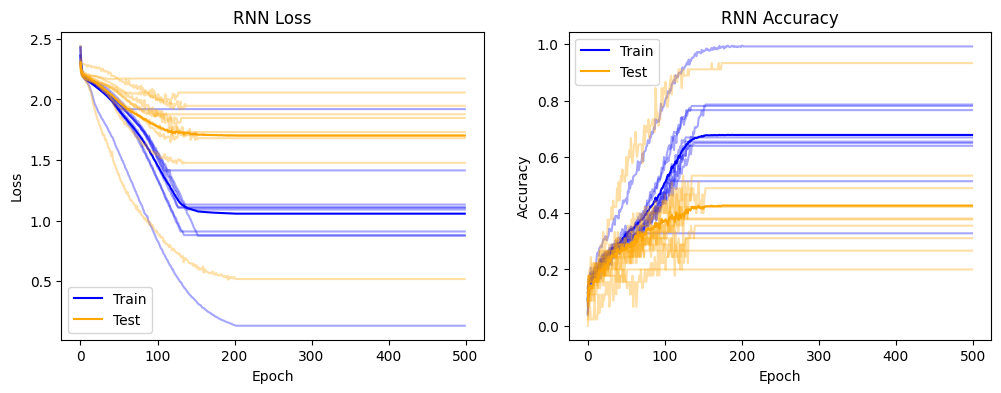

In [26]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [29]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories)

Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
